## import packages

In [39]:
import sqlite3
import pandas as pd
import geopandas as gpd
import networkx as nx
import numpy as np
import nxviz as nv
from nxviz import annotate, layouts
import matplotlib.pyplot as plt
import logging
import sys


## global definitions

In [2]:
palette = [
    "#1f77b4",
    "#ff7f0e",
    "#279e68",
    "#d62728",
    "#aa40fc",
    "#8c564b",
    "#1f77b4",
    "#ff7f0e",
    "#279e68",
    "#d62728",
    "#aa40fc",
    "#8c564b",
]

# logging
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

# Add handler if missing
if not logger.handlers:
    handler = logging.StreamHandler()  # prints to console
    formatter = logging.Formatter("[%(levelname)s] %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)

#### function definitions

In [3]:

def get_properties(nodes, br, ce):
    """
    Prepare node property lookup tables for city names and macro-region metadata.

    Parameters
    ----------
    nodes: list with unique nodes
    br : geopandas.GeoDataFrame
        Municipal dataset with columns `CD_MUN` and `NM_MUN`.
    ce : geopandas.GeoDataFrame
        Macro-region dataset with columns `CD_MUN`, `MACRO_ID`, and `MACRO_NOME`.


    Returns
    -------
    tuple[dict, dict, dict]
        Lookup dictionaries keyed by municipality code: city names, macro names, and macro IDs.
    """
    
    # define dicts to add node and edge properties
    city_names = dict(zip(br["CD_MUN"], br["NM_MUN"]))
    ce_macro_id = dict(zip(ce["CD_MUN"].astype(str).str[:6], ce["MACRO_ID"]))
    ce_macro_name = dict(zip(ce["CD_MUN"].astype(str).str[:6], ce["MACRO_NOME"]))

    macro_ids = []
    macro_names = []
    for n in nodes:
        if ce_macro_id.get(n) is not None:
            macro_ids.append(ce_macro_id[n])
            macro_names.append(ce_macro_name[n])
        else:
            macro_ids.append(9)
            macro_names.append("unknown")

    assert len(macro_ids) == len(nodes), "something wrong with macro_ids"
    assert len(macro_names) == len(nodes), "something wrong with macro_names"

    ce_macro_id   =  None
    ce_macro_name = None

    macro_ids = dict(zip(nodes, macro_ids))
    macro_names = dict(zip(nodes, macro_names))
    
    return (city_names, macro_names, macro_ids)

## cities names and regions

In [4]:
# large file
# br = gpd.read_file("../data/municipios_BR_2022.geojson")

# smaller file
br = pd.read_csv("../data/municipios_BR_2022.csv")
br["CD_MUN"] = br["CD_MUN"].astype(str).str[:6]
ce = gpd.read_file("../data/municipios_CE_2022_Macros.geojson")
ce["MACRO_NOME"] = ce["MACRO_NOME"].str.replace("Superintendência Regional de Saúde ","")
ce["CD_MUN"] = ce["CD_MUN"].astype(str).str[:6]

## the network

#### query database

In [5]:
# require 
# conn: connection to SIH database 
#   MUNIC_RES = código do município de residência
#   MUNIC_MOV = código do município do estabelecimento
#   NASC = Data de nascimento do paciente
#   SEXO = Sexo do paciente
#   MORTE = Indica óbito
#   CID_MORTE = CID da morte
#   DT_INTER = Data de internação
#   DT_SAIDA = Data de saída
#   DIAG_PRINC = Código do diagnóstico principal (CID10)
#   DIAG_SECUN = Código do diagnóstico secundário (CID10)
#   CNES = Código CNES do hospital


# br - all city codes,  names, states
# ce = all city codes,  names, macro regions

In [6]:
conn = sqlite3.connect("../data/opendatasus/SIHSUS_CE_2019-2019.db")

columns = [
    "MUNIC_RES",
    "MUNIC_MOV",
    "NASC",
    "SEXO",
    "MORTE",
    "CID_MORTE",
    "DT_INTER",
    "DT_SAIDA",
    "DIAG_PRINC",
    "DIAG_SECUN",
    "CNES",
]
query = f"""
    SELECT {", ".join(columns)} 
    FROM aih_reduzida
    WHERE
        MUNIC_RES LIKE '23%'
"""

sih = pd.read_sql_query(query, conn)
print(sih.shape)

(44345, 11)


#### unique nodes

In [7]:
nodes = set(sih["MUNIC_RES"])
nodes = nodes | set(sih["MUNIC_MOV"])
nodes = sorted(list(nodes))
    
city_names, macro_names, macro_ids = get_properties(nodes, br,ce)

#### build the network

In [8]:
G = nx.DiGraph()
for n in nodes:
    G.add_node(
        n,
        people_in=0,
        people_out=0,
        mun_name=city_names[n],
        macro_id=macro_ids[n],
        macro_name=macro_names[n],
        name=city_names[n]
    )

for i, row in sih.iterrows():
    u = row["MUNIC_RES"]
    v = row["MUNIC_MOV"]
    G.nodes[u]['people_out'] += 1
    G.nodes[v]['people_in'] += 1
    if G.has_edge(u,v):
        G[u][v]["weight"] += 1  # sum of patients in this edge
    else:
        G.add_edge(u,v, weight=1,
                   source_name = G.nodes[u]["name"],
                   source_macro_name = G.nodes[u]["macro_name"],
                   source_macro_id = G.nodes[u]["macro_id"],
                   target_name = G.nodes[v]["name"],
                   target_macro_name = G.nodes[u]["macro_name"],
                   target_macro_id = G.nodes[u]["macro_id"],
                   )


    
# nx.set_node_attributes(G, dict(G.in_degree()), name="in_degree")
# nx.set_node_attributes(G, dict(G.out_degree()), name="out_degree")  


print(G.nodes(data=True))
print(G.edges(data=True))

[('230010', {'people_in': 0, 'people_out': 50, 'mun_name': 'Abaiara', 'macro_id': 5, 'macro_name': 'Cariri', 'name': 'Abaiara'}), ('230015', {'people_in': 0, 'people_out': 65, 'mun_name': 'Acarape', 'macro_id': 1, 'macro_name': 'Fortaleza', 'name': 'Acarape'}), ('230020', {'people_in': 365, 'people_out': 265, 'mun_name': 'Acaraú', 'macro_id': 4, 'macro_name': 'Norte', 'name': 'Acaraú'}), ('230030', {'people_in': 182, 'people_out': 219, 'mun_name': 'Acopiara', 'macro_id': 5, 'macro_name': 'Cariri', 'name': 'Acopiara'}), ('230040', {'people_in': 22, 'people_out': 82, 'mun_name': 'Aiuaba', 'macro_id': 2, 'macro_name': 'Sertão Central', 'name': 'Aiuaba'}), ('230050', {'people_in': 0, 'people_out': 41, 'mun_name': 'Alcântaras', 'macro_id': 4, 'macro_name': 'Norte', 'name': 'Alcântaras'}), ('230060', {'people_in': 15, 'people_out': 48, 'mun_name': 'Altaneira', 'macro_id': 5, 'macro_name': 'Cariri', 'name': 'Altaneira'}), ('230070', {'people_in': 13, 'people_out': 70, 'mun_name': 'Alto Santo'

## Plot

In [63]:

for u in G.nodes:
    in_degree = G.in_degree(u)
    if in_degree>0:
        G.nodes[u]["node_size"] = np.round(1+np.log(in_degree)/5, decimals=3) 
    else:
         G.nodes[u]["node_size"] = 1
        

for e in G.edges:
    u,v = e
    G[u][v]["edge_lw"] = 1+np.log(G[u][v]["weight"])/10
    G[u][v]["edge_alpha"] = np.log(G[u][v]["weight"])/100
    

legend_kwargs = {
        "ncol": 2,
        "bbox_to_anchor": (1, 0.5),
        "frameon": False,
        "loc": "center left",
    }

colors = dict(zip(set(macro_names.values()),set(palette)))

/opt/miniconda3/envs/opensus/lib/python3.13/site-packages/nxviz/annotate.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  groups = nt.groupby(group_by).apply(lambda df: len(df)).sort_index()
/tmp/ipykernel_82338/2526260075.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  xy = row.pos[0]
/tmp/ipykernel_82338/2526260075.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To acc

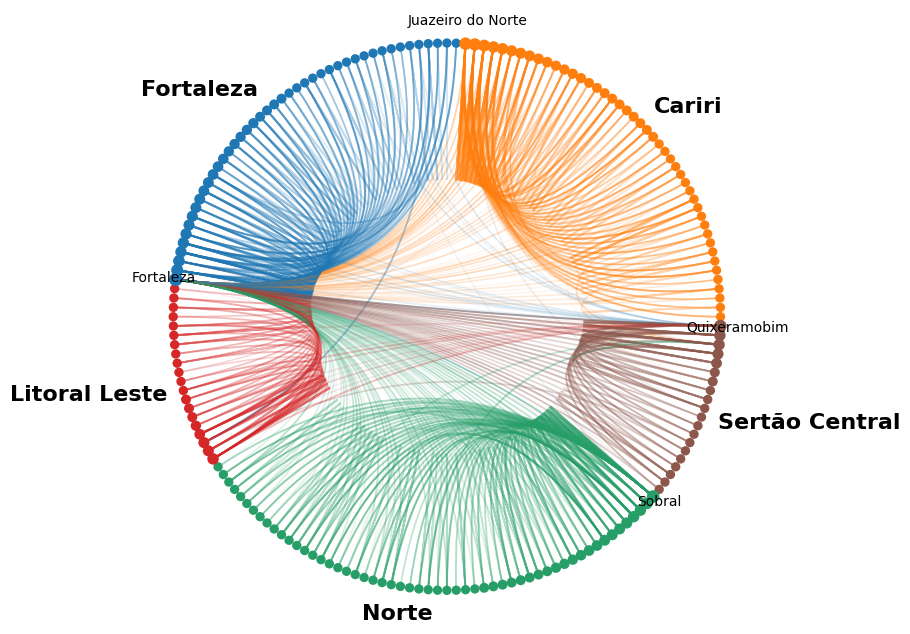

In [118]:
fig, ax_c = plt.subplots(1, figsize=(10,10))

nt = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index') #.reset_index()
nt = nt.sort_values(["macro_name", "node_size"])
pos = layouts.circos(nt, group_by="macro_name", sort_by="node_size")
nt['pos'] = [pos[n] for n in nt.index]

ax = nv.circos(
    G,
    group_by="macro_name",
    sort_by="node_size",
    node_size_by="node_size",
    node_color_by="macro_name",
    node_palette=colors,
    edge_lw_by = "edge_lw",
    edge_color_by="source_macro_name",
    edge_palette=colors,
    edge_alpha_by="edge_alpha",
)

annotate.circos_group(G,group_by="macro_name", radius_offset=3, fontdict={'size': 16, 'weight': 'bold' })
nt = nt.sort_values(by="node_size", ascending=False)


for i in [0,1,2,3]:
    row = nt.iloc[[i]]
    xy = row.pos[0]
    text = row.mun_name[0]
    xytext =len(text)*xy/np.linalg.norm(xy)
        
    ax.annotate(text, xy=xy, xytext=xytext,textcoords='offset points',
                        ha='center', va='center')
plt.tight_layout(rect=(0.05, 0.05, 0.95, 0.95))

plt.show()

In [93]:

nt=nt.sort_values(by="node_size", ascending=False)
nt.iloc[[0]].mun_name[0]


/tmp/ipykernel_82338/2445199815.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  nt.iloc[[0]].mun_name[0]


'Fortaleza'

# Versão do Higor

In [41]:
def group_colormap_macro(data : pd.Series):
    cmap = {1: "#1f77b4", 2: "#ff7f0e", 3: "#279e68", 4: "#d62728", 5: "#aa40fc"}
    return data.apply(lambda x: cmap.get(x))

def group_colormap_edges(data : pd.Series):
    cmap = {1: "#1f77b4", 2: "#ff7f0e", 3: "#279e68", 4: "#d62728", 5: "#aa40fc", -1: "#9c9c9c"}
    return data.apply(lambda x: cmap.get(x))
def group_colormap_edges_transparency(data : pd.Series):
    cmap = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, -1: 1}
    return data.apply(lambda x: cmap.get(x))
def rescale(G: nx.Graph):
    """Default rescale."""
    ax = plt.gca()
    ax.relim()
    ax.autoscale_view()
def aspect_equal(ax=None):
    """Set aspect ratio of an axes object to be equal."""
    if ax is None:
        ax = plt.gca()
    ax.set_aspect("equal")
def despine(ax=None):
    """Remove all spines (and ticks) from the matplotlib axes."""
    if ax is None:
        ax = plt.gca()
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

In [46]:
nt = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index') #.reset_index()
nt = nt.sort_values(["macro_name", "node_size"])


In [43]:
et = pd.DataFrame([
    {'source': u, 'target': v, **d}
    for u, v, d in G.edges(data=True)
])

/opt/miniconda3/envs/opensus/lib/python3.13/site-packages/nxviz/annotate.py:68: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  groups = nt.groupby(group_by).apply(lambda df: len(df)).sort_index()


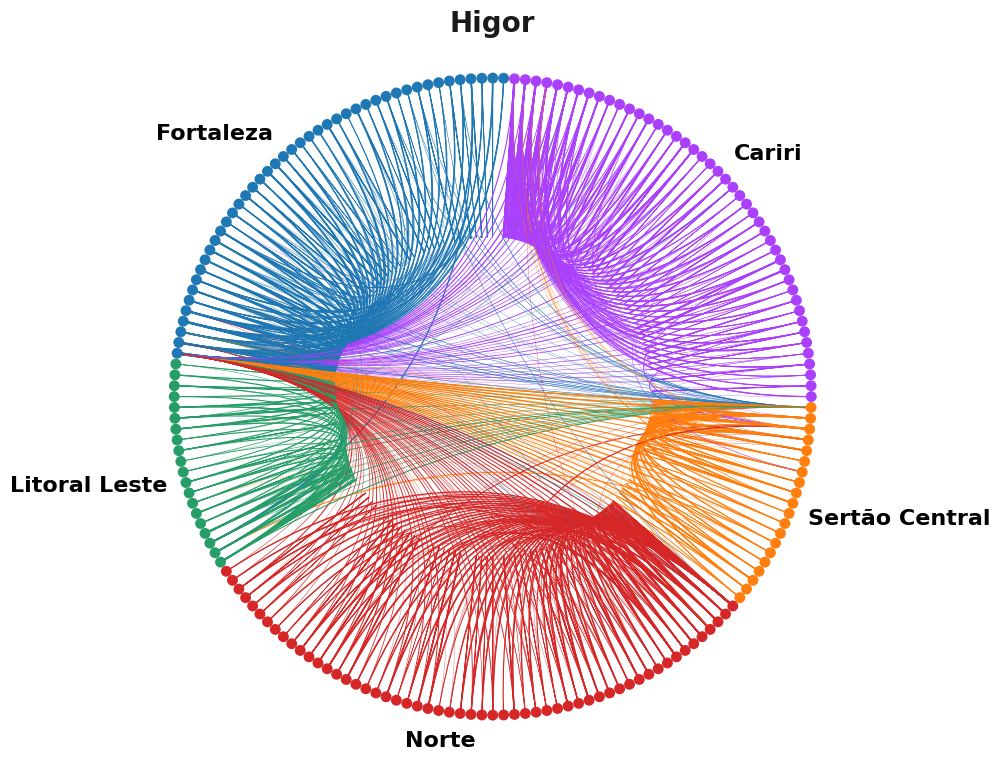

In [44]:
fig_circos, ax_circos = plt.subplots(1, figsize=(10,10))
pos = layouts.circos(nt, group_by="macro_name", sort_by="node_size")
annotate.circos_group(G, group_by="macro_name", ax=ax_circos, radius_offset=3, fontdict={'size': 16, 'weight': 'bold' })
node_color = group_colormap_macro(nt["macro_id"])
alpha = nv.nodes.transparency(nt, alpha_by=None)
size = nv.nodes.node_size(nt, size_by=None)
patches = nv.nodes.node_glyphs(
    nt, pos, node_color=node_color, alpha=alpha, size=size
)
for patch in patches:
    ax_circos.add_patch(patch)

edge_color = group_colormap_edges(et["source_macro_id"])
edge_linewidth = et["edge_lw"]/5
alpha = group_colormap_edges_transparency(et["edge_lw"]/100)
patches = nv.lines.circos(
    et, pos, edge_color=edge_color, alpha=alpha, lw=edge_linewidth, aes_kw={"fc": "none"}
)
for patch in patches:
    ax_circos.add_patch(patch)
rescale(G)
aspect_equal()
despine()
ax_circos.set_title("Higor", fontsize=20, color="#1a1a1a", weight='bold')
fig_circos.tight_layout()
plt.show()

In [24]:
et

,source,target,weight,source_name,source_macro_name,source_macro_id,target_name,target_macro_name,target_macro_id,edge_lw
0,230010,230730,3,Abaiara,Cariri,5,Juazeiro do Norte,Cariri,5,2.098612
1,230010,230190,8,Abaiara,Cariri,5,Barbalha,Cariri,5,3.079442
2,230010,230250,38,Abaiara,Cariri,5,Brejo Santo,Cariri,5,4.637586
3,230010,230440,1,Abaiara,Cariri,5,Fortaleza,Cariri,5,1.000000
4,230015,230765,18,Acarape,Fortaleza,1,Maracanaú,Fortaleza,1,3.890372
...,...,...,...,...,...,...,...,...,...,...
916,231400,230440,8,Várzea Alegre,Cariri,5,Fortaleza,Cariri,5,3.079442
917,231410,231290,55,Viçosa do Ceará,Norte,4,Sobral,Norte,4,5.007333
918,231410,231340,30,Viçosa do Ceará,Norte,4,Tianguá,Norte,4,4.401197
919,231410,231410,151,Viçosa do Ceará,Norte,4,Viçosa do Ceará,Norte,4,6.017280
